# Masinsko ucenje
#### Aleksandar Gavric

## Klasifikacija slika otpada na klase karton, staklo, metal, papir, plastika ili djubre

Zagađenje recikliranjem nastaje kada se otpad nepravilno odlaže - poput recikliranja kutije za picu sa uljem na njoj (kompost). Ili kada se otpad pravilno odlaže, ali pogrešno priprema - poput recikliranja neispranih tegli za džem.
Kontaminacija je veliki problem u reciklažnoj industriji koji se može ublažiti automatskim optičkim sortiranjem otpada.

Obučavamo konvolucionu neuronsku mrežu da klasifikuje sliku kao karton, staklo, metal, papir, plastiku ili smeće.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [2]:
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns
import random

## 1. Ekstraktovanje podataka

Ekstraktovanje podataka koji su u "dataset-resized.zip".

In [4]:
files = zf.ZipFile("dataset-resized.zip",'r')
files.extractall()
files.close()

imamo 6 potfoldera:

In [3]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['.DS_Store', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

## 2. Reorganizacija slika u foldere test, valid i train

Pravimo foldere train, validation, i test sa 50-25-25 % splitom originalnog seta. 

In [3]:
def split_indices(folder,seed1,seed2):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.5*n))

    remain = list(set(full_set)-set(train))

    random.seed(seed2)
    valid = random.sample(remain,int(.5*len(remain)))
    test = list(set(remain)-set(valid))
    
    return(train,valid,test)

def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

Pravimo direktorijume po konvenciji takmicenja ImageNet. Izgledace ovako:

/data <br>
&nbsp;&nbsp;&nbsp;&nbsp; /train <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>
&nbsp;&nbsp;&nbsp;&nbsp; /valid <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /cardboard <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /glass <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /metal <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /paper <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /plastic <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;    /trash <br>
&nbsp;&nbsp;&nbsp;&nbsp;/test <br>

Nazivi slika ce biti klasa i redni broj slike (npr. cardboard1.jpg)

In [4]:
subsets = ['train','valid']
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

In [9]:
for subset in subsets:
    for waste_type in waste_types:
        folder = os.path.join('data',subset,waste_type)
        if not os.path.exists(folder):
            os.makedirs(folder)
            
if not os.path.exists(os.path.join('data','test')):
    os.makedirs(os.path.join('data','test'))
            
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind, valid_ind, test_ind = split_indices(source_folder,1,1)
    
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    valid_names = get_names(waste_type,valid_ind)
    valid_source_files = [os.path.join(source_folder,name) for name in valid_names]
    valid_dest = "data/valid/"+waste_type
    move_files(valid_source_files,valid_dest)
    
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    
    move_files(test_source_files,"data/test")

Stavljamo random seed na 1 zbog reproduktivnosti

In [6]:
path = Path(os.getcwd())/"data"
path

WindowsPath('C:/HOME/MU3/data')

In [5]:
img_width, img_height = 32, 32 #224, 224
batch_size = 32
num_classes = 6

In [9]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [7]:
project_dir = str(path)
trainset_dir = project_dir+'\\train'
testset_dir = project_dir+'\\valid'

In [10]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    trainset_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size)

test_generator = test_datagen.flow_from_directory(
    testset_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size)

Found 1262 images belonging to 6 classes.
Found 630 images belonging to 6 classes.


In [11]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, BatchNormalization
from keras import backend as K
from keras import optimizers, regularizers, Model
from keras.applications import densenet

In [12]:
def generate_transfer_model(input_shape, num_classes):
    base_model = densenet.DenseNet121(
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        input_shape=input_shape,
        pooling='max')

    x = base_model.output
    #x = Dense(256, activation="relu")(x)
    x = Dense(16, activation="elu", kernel_regularizer=regularizers.l2(0.1))(x)
    x = Dropout(0.6)(x)
    x = BatchNormalization()(x)
    predictions = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    #optimizer = optimizers.Adam(lr=0.0001)
    optimizer = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [13]:
from keras import backend as K

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

print("generisanje modela")
model = generate_transfer_model(input_shape, num_classes)

generisanje modela













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




Pocelo fitovanje
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
40/40 [==============================] - 85s 2s/step - loss: 4.9510 - acc: 0.2653 - val_loss: 4.2657 - val_acc: 0.4381
Epoch 2/50
40/40 [==============================] - 36s 895ms/step - loss: 4.1647 - acc: 0.3830 - val_loss: 3.6711 - val_acc: 0.5254
Epoch 3/50
40/40 [==============================] - 35s 876ms/step - loss: 3.5747 - acc: 0.4855 - val_loss: 3.1695 - val_acc: 0.5889
Epoch 4/50
40/40 [==============================] - 35s 887ms/step - loss: 3.1568 - acc: 0.5311 - val_loss: 2.8008 - val_acc: 0.6365
Epoch 5/50
40/40 [==============================] - 36s 890ms/step - loss: 2.8496 - acc: 0.5662 - val_loss: 2.5050 - val_acc: 0.6794
Epoch 6/50
40/40 [==============================] - 37s 918ms/step - loss: 2.5315 - acc: 0.5981 - val_loss: 2.2621 - val_acc: 0.6635
Epoch 7/50
40/40 [==============================] - 35s 882ms/step - loss: 2.2299 - acc: 0.6

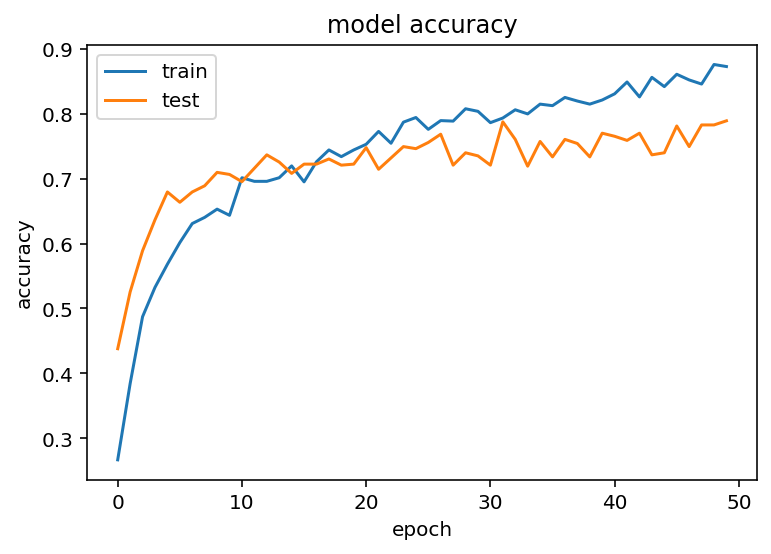

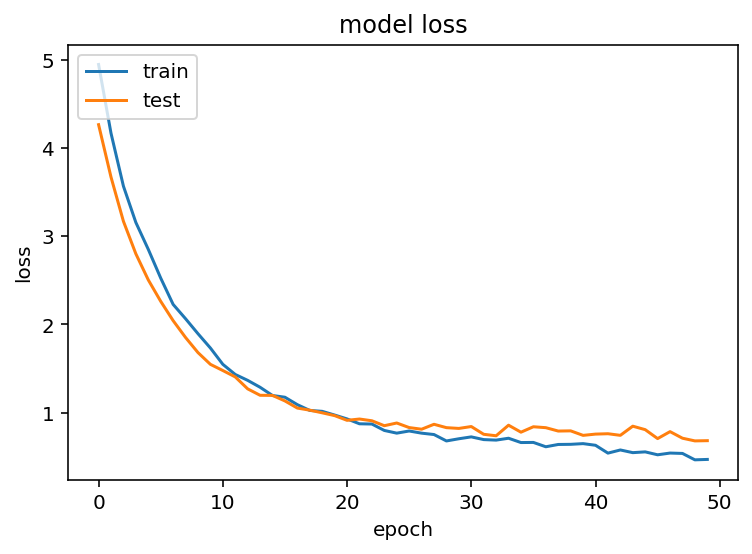

In [14]:
import matplotlib.pyplot as plt
import numpy as np

n_epochs = 50
training_period = 3
load_weights_file = project_dir+'weights_save_{}.h5'.format(training_period)
save_weights_file = project_dir+'weights_save_{}.h5'.format(training_period+1)

def load_weights():
    print("Ucitane tezine")
    model.load_weights(load_weights_file)

def fit(n_epochs):
    print("Pocelo fitovanje")
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=n_epochs,
        validation_data=test_generator,
        validation_steps=len(test_generator))
    
    print("Cuvanje tezina")
    model.save_weights(save_weights_file)
    
    print(history.history.keys())
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def print_layers():
    for layer in model.layers:
        print(layer.name)
        print("trainable: "+str(layer.trainable))
        print("input_shape: " + str(layer.input_shape))
        print("output_shape: " + str(layer.output_shape))
        print("_____________")

    

load_weights()
#fit(n_epochs)

In [15]:
print_layers()

input_1
trainable: False
input_shape: (None, 32, 32, 3)
output_shape: (None, 32, 32, 3)
_____________
zero_padding2d_1
trainable: True
input_shape: (None, 32, 32, 3)
output_shape: (None, 38, 38, 3)
_____________
conv1/conv
trainable: True
input_shape: (None, 38, 38, 3)
output_shape: (None, 16, 16, 64)
_____________
conv1/bn
trainable: True
input_shape: (None, 16, 16, 64)
output_shape: (None, 16, 16, 64)
_____________
conv1/relu
trainable: True
input_shape: (None, 16, 16, 64)
output_shape: (None, 16, 16, 64)
_____________
zero_padding2d_2
trainable: True
input_shape: (None, 16, 16, 64)
output_shape: (None, 18, 18, 64)
_____________
pool1
trainable: True
input_shape: (None, 18, 18, 64)
output_shape: (None, 8, 8, 64)
_____________
conv2_block1_0_bn
trainable: True
input_shape: (None, 8, 8, 64)
output_shape: (None, 8, 8, 64)
_____________
conv2_block1_0_relu
trainable: True
input_shape: (None, 8, 8, 64)
output_shape: (None, 8, 8, 64)
_____________
conv2_block1_1_conv
trainable: True
input_

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import pandas as pd
import tensorflow as tf

def print_classification_report():
    # Confution Matrix and Classification Report
    Y_pred = model.predict_generator(test_generator, len(test_generator))
    y_pred = np.argmax(Y_pred, axis=1)

    print('Classification Report')
    target_names = list(test_generator.class_indices.keys())
    print(classification_report(test_generator.classes, y_pred, target_names=target_names))
    
    print('Confusion Matrix')
    conf_mat = confusion_matrix(test_generator.classes, y_pred)
    df_cm = pd.DataFrame(conf_mat, index = target_names, columns = target_names)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    
def save_model():
    print("sacuvavanje modela")
    
    keras_file = project_dir+"keras_model.h5"
    model.save(keras_file)
    converter = tf.lite.TFLiteConverter.from_keras_model_file(keras_file)
    tflite_model = converter.convert()
    converted_file = project_dir+"converted_model.tflite"
    open(converted_file, "wb").write(tflite_model)

    print("model je sacuvan.")


Classification Report
              precision    recall  f1-score   support

   cardboard       0.13      0.12      0.12       101
       glass       0.16      0.14      0.15       125
       metal       0.17      0.20      0.18       102
       paper       0.23      0.26      0.24       148
     plastic       0.18      0.17      0.17       120
       trash       0.12      0.09      0.10        34

    accuracy                           0.18       630
   macro avg       0.17      0.16      0.16       630
weighted avg       0.17      0.18      0.18       630

Confusion Matrix


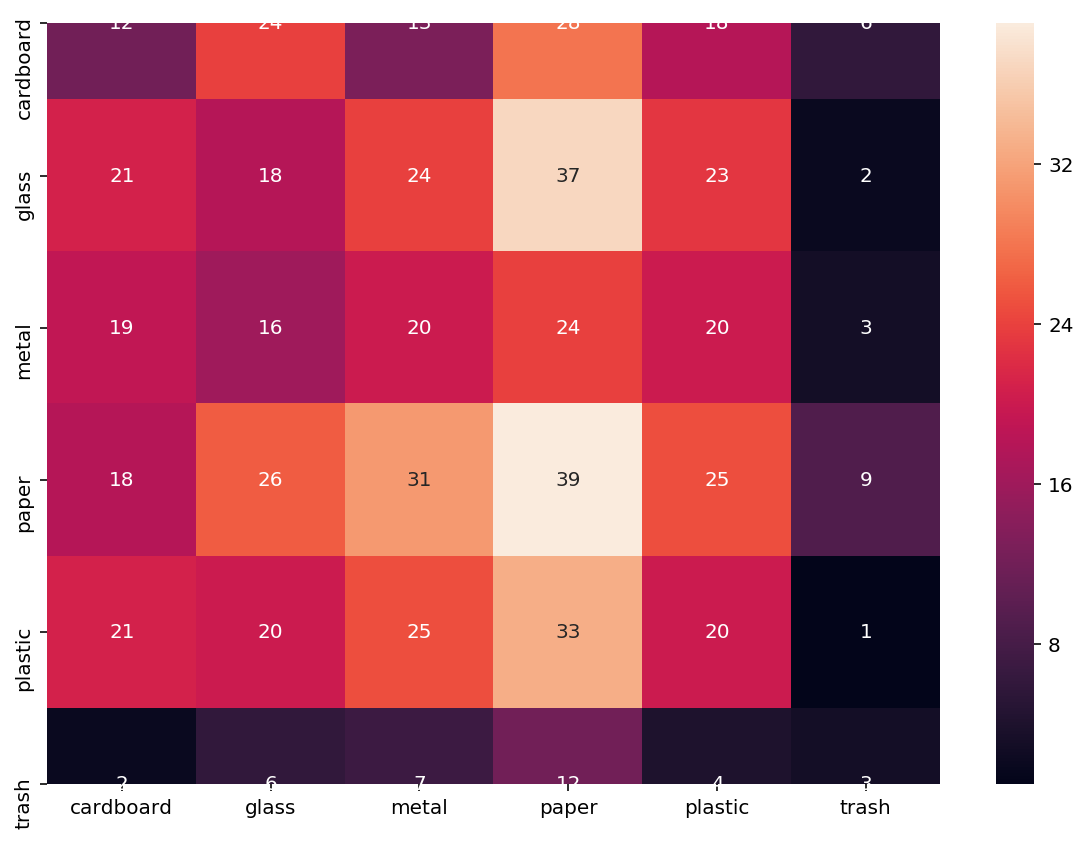

In [20]:
#load_weights()
print_classification_report()

In [19]:
save_model()

sacuvavanje modela
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 612 variables.
INFO:tensorflow:Converted 612 variables to const ops.
model je sacuvan.
